In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 75            # Fine-tuning
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10

# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/WGAN/saved_models"
fine_tune_model_dir = "/content/drive/MyDrive/WGAN/saved_models_als_left"
sample_dir = "/content/drive/MyDrive/WGAN/generated_samples_als_left"
data_path = "/content/drive/MyDrive/gaitndd_dataset/processed_data/windows_gait/Splited_Data/als_all_left.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation des modèles ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur les contrôles ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets contrôles")

# === Chargement des données ALS gauche ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # === Critic ===
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # === Generator ===
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Lancer l'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # === Sauvegarde périodique ===
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour ALS pied gauche")


✓ Poids préentraînés chargés depuis les sujets contrôles


Epoch 1/75: 100%|██████████| 13/13 [02:49<00:00, 13.07s/it]



Epoch 1 | Critic: -9.1724 | Generator: 13.2665


Epoch 2/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 2 | Critic: -13.5133 | Generator: 5.5388


Epoch 3/75: 100%|██████████| 13/13 [02:45<00:00, 12.74s/it]



Epoch 3 | Critic: -12.7533 | Generator: 9.7057


Epoch 4/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 4 | Critic: -11.9421 | Generator: 16.1677


Epoch 5/75: 100%|██████████| 13/13 [02:45<00:00, 12.73s/it]



Epoch 5 | Critic: -11.7748 | Generator: 21.3599


Epoch 6/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 6 | Critic: -10.1394 | Generator: 20.6803


Epoch 7/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 7 | Critic: -7.6573 | Generator: 16.4928


Epoch 8/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 8 | Critic: -5.5733 | Generator: 13.4309


Epoch 9/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 9 | Critic: -4.8449 | Generator: 11.1974


Epoch 10/75: 100%|██████████| 13/13 [02:43<00:00, 12.55s/it]



Epoch 10 | Critic: -4.0188 | Generator: 8.8220


Epoch 11/75: 100%|██████████| 13/13 [02:44<00:00, 12.69s/it]



Epoch 11 | Critic: -3.5244 | Generator: 8.8853


Epoch 12/75: 100%|██████████| 13/13 [02:44<00:00, 12.68s/it]



Epoch 12 | Critic: -3.6487 | Generator: 4.5232


Epoch 13/75: 100%|██████████| 13/13 [02:43<00:00, 12.60s/it]



Epoch 13 | Critic: -3.4169 | Generator: 5.6627


Epoch 14/75: 100%|██████████| 13/13 [02:44<00:00, 12.68s/it]



Epoch 14 | Critic: -3.3199 | Generator: 5.7091


Epoch 15/75: 100%|██████████| 13/13 [02:44<00:00, 12.68s/it]



Epoch 15 | Critic: -3.2717 | Generator: 4.2295


Epoch 16/75: 100%|██████████| 13/13 [02:43<00:00, 12.60s/it]



Epoch 16 | Critic: -3.3642 | Generator: 4.2771


Epoch 17/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 17 | Critic: -3.2950 | Generator: 3.8477


Epoch 18/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 18 | Critic: -3.3772 | Generator: 2.9157


Epoch 19/75: 100%|██████████| 13/13 [02:43<00:00, 12.61s/it]



Epoch 19 | Critic: -3.4601 | Generator: 5.0150


Epoch 20/75: 100%|██████████| 13/13 [02:44<00:00, 12.65s/it]



Epoch 20 | Critic: -3.3147 | Generator: 4.9701


Epoch 21/75: 100%|██████████| 13/13 [02:44<00:00, 12.68s/it]



Epoch 21 | Critic: -3.3245 | Generator: 3.3875


Epoch 22/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 22 | Critic: -3.4495 | Generator: 2.4222


Epoch 23/75: 100%|██████████| 13/13 [02:43<00:00, 12.59s/it]



Epoch 23 | Critic: -3.3848 | Generator: 1.5552


Epoch 24/75: 100%|██████████| 13/13 [02:46<00:00, 12.81s/it]



Epoch 24 | Critic: -3.4008 | Generator: 2.9595


Epoch 25/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 25 | Critic: -3.2772 | Generator: 2.3095


Epoch 26/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 26 | Critic: -3.3034 | Generator: 3.2649


Epoch 27/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 27 | Critic: -3.6016 | Generator: 2.4896


Epoch 28/75: 100%|██████████| 13/13 [02:45<00:00, 12.73s/it]



Epoch 28 | Critic: -3.2528 | Generator: 2.0005


Epoch 29/75: 100%|██████████| 13/13 [02:45<00:00, 12.76s/it]



Epoch 29 | Critic: -3.1327 | Generator: 4.0668


Epoch 30/75: 100%|██████████| 13/13 [02:43<00:00, 12.57s/it]



Epoch 30 | Critic: -3.4192 | Generator: 0.7652


Epoch 31/75: 100%|██████████| 13/13 [02:44<00:00, 12.67s/it]



Epoch 31 | Critic: -3.1145 | Generator: 1.6488


Epoch 32/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 32 | Critic: -3.4558 | Generator: 1.7175


Epoch 33/75: 100%|██████████| 13/13 [02:46<00:00, 12.83s/it]



Epoch 33 | Critic: -3.1187 | Generator: 2.4770


Epoch 34/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 34 | Critic: -3.2383 | Generator: 0.5931


Epoch 35/75: 100%|██████████| 13/13 [02:44<00:00, 12.69s/it]



Epoch 35 | Critic: -3.3868 | Generator: 1.1895


Epoch 36/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 36 | Critic: -3.3623 | Generator: 0.6596


Epoch 37/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 37 | Critic: -3.3606 | Generator: -0.9195


Epoch 38/75: 100%|██████████| 13/13 [02:42<00:00, 12.54s/it]



Epoch 38 | Critic: -3.1132 | Generator: -0.2680


Epoch 39/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 39 | Critic: -3.1317 | Generator: -0.6968


Epoch 40/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 40 | Critic: -3.0238 | Generator: -2.9771


Epoch 41/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 41 | Critic: -3.3236 | Generator: -5.7987


Epoch 42/75: 100%|██████████| 13/13 [02:44<00:00, 12.68s/it]



Epoch 42 | Critic: -3.0233 | Generator: -5.3616


Epoch 43/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 43 | Critic: -3.1898 | Generator: -4.3645


Epoch 44/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 44 | Critic: -3.0755 | Generator: -4.8580


Epoch 45/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 45 | Critic: -3.1480 | Generator: -4.0191


Epoch 46/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 46 | Critic: -2.9696 | Generator: -3.5347


Epoch 47/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 47 | Critic: -2.9837 | Generator: -2.8441


Epoch 48/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 48 | Critic: -2.6631 | Generator: 0.1894


Epoch 49/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 49 | Critic: -2.9378 | Generator: -0.8338


Epoch 50/75: 100%|██████████| 13/13 [02:45<00:00, 12.75s/it]



Epoch 50 | Critic: -2.8588 | Generator: 1.0525


Epoch 51/75: 100%|██████████| 13/13 [02:46<00:00, 12.81s/it]



Epoch 51 | Critic: -3.0399 | Generator: 2.7441


Epoch 52/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 52 | Critic: -2.9287 | Generator: 7.1510


Epoch 53/75: 100%|██████████| 13/13 [02:45<00:00, 12.75s/it]



Epoch 53 | Critic: -2.7493 | Generator: 12.4021


Epoch 54/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 54 | Critic: -2.8447 | Generator: 12.2017


Epoch 55/75: 100%|██████████| 13/13 [02:45<00:00, 12.72s/it]



Epoch 55 | Critic: -2.6650 | Generator: 11.5646


Epoch 56/75: 100%|██████████| 13/13 [02:44<00:00, 12.64s/it]



Epoch 56 | Critic: -2.5024 | Generator: 9.5661


Epoch 57/75: 100%|██████████| 13/13 [02:45<00:00, 12.71s/it]



Epoch 57 | Critic: -3.0445 | Generator: 9.9757


Epoch 58/75: 100%|██████████| 13/13 [02:45<00:00, 12.74s/it]



Epoch 58 | Critic: -2.8630 | Generator: 13.3997


Epoch 59/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 59 | Critic: -2.8461 | Generator: 12.2288


Epoch 60/75: 100%|██████████| 13/13 [02:45<00:00, 12.72s/it]



Epoch 60 | Critic: -2.6951 | Generator: 9.1871


Epoch 61/75: 100%|██████████| 13/13 [02:45<00:00, 12.74s/it]



Epoch 61 | Critic: -2.8305 | Generator: 4.9093


Epoch 62/75: 100%|██████████| 13/13 [02:46<00:00, 12.79s/it]



Epoch 62 | Critic: -2.9369 | Generator: -0.9519


Epoch 63/75: 100%|██████████| 13/13 [02:43<00:00, 12.59s/it]



Epoch 63 | Critic: -2.9312 | Generator: 7.0170


Epoch 64/75: 100%|██████████| 13/13 [02:44<00:00, 12.63s/it]



Epoch 64 | Critic: -2.5088 | Generator: 15.6089


Epoch 65/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 65 | Critic: -2.4503 | Generator: 12.5956


Epoch 66/75: 100%|██████████| 13/13 [02:45<00:00, 12.74s/it]



Epoch 66 | Critic: -2.3822 | Generator: 11.7360


Epoch 67/75: 100%|██████████| 13/13 [02:44<00:00, 12.63s/it]



Epoch 67 | Critic: -2.1129 | Generator: 8.5207


Epoch 68/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 68 | Critic: -2.0200 | Generator: 12.3931


Epoch 69/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 69 | Critic: -2.4778 | Generator: 15.2719


Epoch 70/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 70 | Critic: -2.4477 | Generator: 7.4060


Epoch 71/75: 100%|██████████| 13/13 [02:44<00:00, 12.63s/it]



Epoch 71 | Critic: -2.2646 | Generator: 8.5619


Epoch 72/75: 100%|██████████| 13/13 [02:45<00:00, 12.70s/it]



Epoch 72 | Critic: -2.1851 | Generator: 14.9913


Epoch 73/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 73 | Critic: -2.3426 | Generator: 16.2683


Epoch 74/75: 100%|██████████| 13/13 [03:21<00:00, 15.53s/it]



Epoch 74 | Critic: -2.3754 | Generator: 15.5423


Epoch 75/75: 100%|██████████| 13/13 [02:45<00:00, 12.73s/it]


Epoch 75 | Critic: -2.3611 | Generator: 17.4001
✓ Fine-tuning terminé pour ALS pied gauche


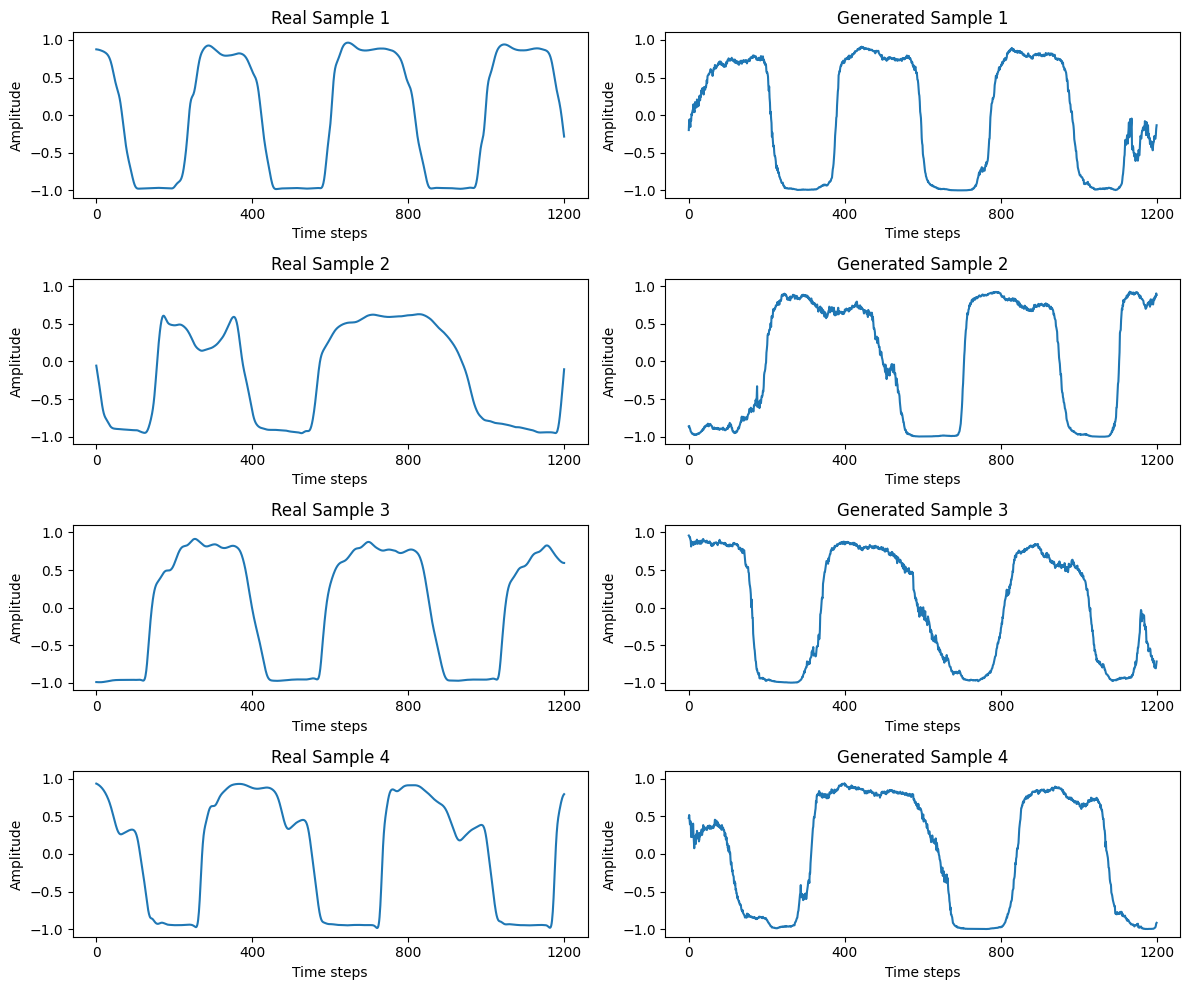

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt




# Parameters
NOISE_DIM = 64
num_samples = 4  # Match the number of samples in your image

# Define generator (same as in your training code)
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# Load real data
data_path = "/content/drive/MyDrive/gaitndd_dataset/processed_data/windows_gait/Splited_Data/als_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1  # Normalize to [-1, 1]
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# Load generator
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/WGAN/saved_models_als_left/generator_epoch_70.weights.h5')

# Generate samples
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# Plotting
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    # Real Sample
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(real_samples[i, :])
    plt.title(f'Real Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

    # Generated Sample
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f'Generated Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

plt.tight_layout()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.02020879134682523
🔄 Average DTW Distance: 12.868147283172199
🔁 Average Cross-Correlation: -0.002836380165557626


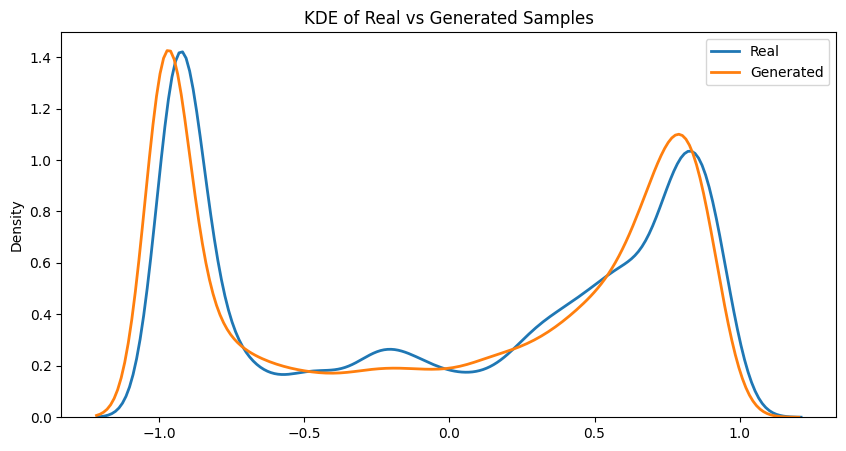

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples = 100  # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/gaitndd_dataset/processed_data/windows_gait/Splited_Data/als_all_left.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/WGAN/saved_models_als_left/generator_epoch_70.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()
